In [9]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = './cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count, 4, 4, 512)) # VGG 捲基層的輸出為(4,4,512)
    labels = np.zeros(shape = (sample_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size = (150, 150),
                                           batch_size = batch_size,
                                           class_mode = 'binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1)* batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        print(i, end = ' ') #萃取時間較久, 所以印出i 來察看進度
        
        if i * batch_size >= sample_count:
            break #產生器會無限產生影像資料,所以在每個影像被萃取過特徵後,就執行break
    
    return features, labels

train_feautres, train_labels = extract_features(train_dir, 2000) #樣本數
validation_features, valiation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 Found 1000 images belonging to 2 classes.
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 Found 1000 images belonging to 2 classes.
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

In [10]:
print('before:train_feautres', train_feautres.shape)

train_feautres = np.reshape(train_feautres, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_feautres = np.reshape(test_features, (1000, 4*4*512))

print('after:train_feautres', train_feautres.shape)

before:train_feautres (2000, 4, 4, 512)
after:train_feautres (2000, 8192)


In [11]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (150,150,3))

model = models.Sequential()
model.add(conv_base) #將捲積基底視為層加入Sequential 模型中
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [13]:
#凍結convolutional base 卷積基底,避免訓練其中更新權重,導致140萬個參數要填整

print('This is the number of trainable weights'
     'before freezing the conv base:', len(model.trainable_weights)) #30個weights哪裡來的?

conv_base.trainable = False

print('This is the number of trainable weights'
     'after freezing the conv base:', len(model.trainable_weights))#為什麼變成4個?

This is the number of trainable weightsbefore freezing the conv base: 30
This is the number of trainable weightsafter freezing the conv base: 4


In [15]:
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
from tensorflow.keras import optimizers

train_datagen = ImageDataGenerator(
            rescale = 1./255,
            rotation_range = 40,
            width_shift_range =0.2,
            height_shift_range = 0.2,
            shear_range = 0.2,
            zoom_range = 0.2,
            horizontal_flip = True,
            fill_mode = 'nearest')

test_datagen = ImageDataGenerator(rescale = 1./255) #為什麼test不做 normalization


train_generator = train_datagen.flow_from_directory(
                train_dir,
                target_size = (150,150),
                batch_size = 20,
                class_mode = 'binary')


validation_generator = test_datagen.flow_from_directory(
                    validation_dir,
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = 'binary')

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(lr = 2e-5),
             metrics = ['acc'])


history = model.fit_generator(
            train_generator,
            steps_per_epoch = 100,
            epochs = 30,
            validation_data = validation_generator,
            validation_steps = 50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 15s 154ms/step - loss: 0.6091 - acc: 0.6600 - val_loss: 0.4575 - val_acc: 0.8220
Epoch 2/30
100/100 [==============================] - 15s 153ms/step - loss: 0.4898 - acc: 0.7760 - val_loss: 0.3814 - val_acc: 0.8360
Epoch 3/30
100/100 [==============================] - 15s 152ms/step - loss: 0.4286 - acc: 0.8100 - val_loss: 0.3578 - val_acc: 0.8480
Epoch 4/30
100/100 [==============================] - 15s 153ms/step - loss: 0.3999 - acc: 0.8205 - val_loss: 0.3088 - val_acc: 0.8790
Epoch 5/30
100/100 [==============================] - 15s 153ms/step - loss: 0.3824 - acc: 0.8290 - val_loss: 0.3064 - val_acc: 0.8650
Epoch 6/30
100/100 [==============================] - 15s 153ms/step - loss: 0.3757 - acc: 0.8390 - val_loss: 0.2892 - val_acc: 0.8770
Epoch 7/30
100/100 [==============================] - 16s 156ms/step - loss: 0.3720 - acc: 0.8275 - val_lo

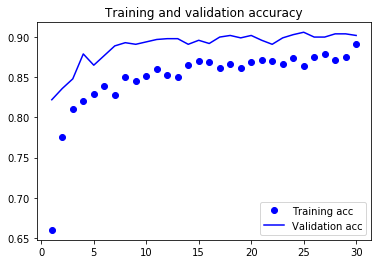

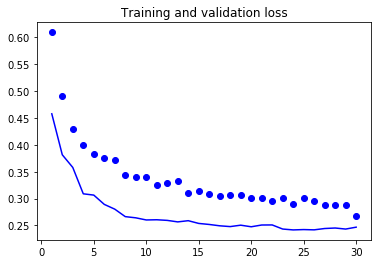

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)


plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b',label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()


plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')

plt.show()